In [2]:
# %matplotlib notebook # comment this line when working in VSCode
import aipy, uvtools
import numpy as np
import pylab as plt
import random
import math

from hera_sim import foregrounds, noise, sigchain, rfi

import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [3]:
def plot_one_vis(vis, ylim):
    plt.figure()
    plt.subplot(211); uvtools.plot.waterfall(vis, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,ylim)
    plt.subplot(212); uvtools.plot.waterfall(vis, mode='phs'); plt.colorbar(); plt.ylim(0,ylim)
    plt.show()

MX, DRNG = 2.5, 3

dataset = np.load('dataset.npy')
labels = np.load('labels.npy')

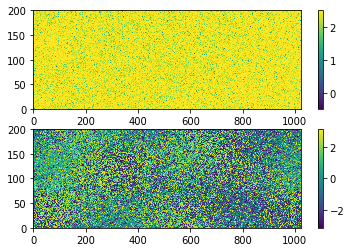

In [16]:
# initialize test point
test_pt = dataset[7]
plot_one_vis(test_pt, 200)

# test_pt = np.expand_dims(test_pt, axis=0) # add dimension of 1 at front

- ReLu activation function: for x, it returns max(0, x)
- He weight initialization is a good option: https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78

In [17]:
# configure the dataset
X, y = dataset, labels
X = X.astype('float32')

# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33) # train_test_split does a random split
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
n_features = (X_train.shape[1], X_train.shape[2])
# print(n_features)

# define model
model = tf.keras.Sequential()
model.add(layers.Flatten(input_shape=n_features))
model.add(layers.Dense(10, activation='relu', kernel_initializer='he_normal'))
model.add(layers.Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(layers.Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model
model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)

# evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

# make a prediction
# yhat = model.predict([test_pt]) # predict one point
# print('Predicted: %.3f' % yhat)

predictions = model.predict_classes(X)
predictions = predictions.flatten()
faulty_predictions = []
for i in range(len(predictions)):
	if predictions[i] != y[i]:
		faulty_predictions.append(i)

print(faulty_predictions)

Test Accuracy: 1.000
[6, 7, 14]


### Visualize faulty predictions

6


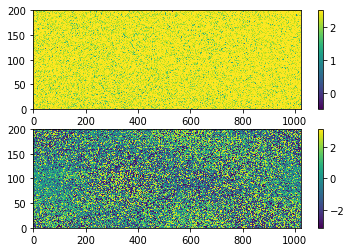

7


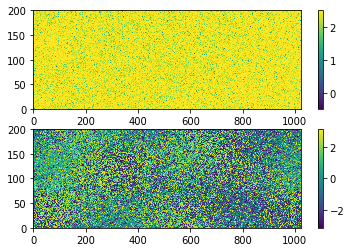

14


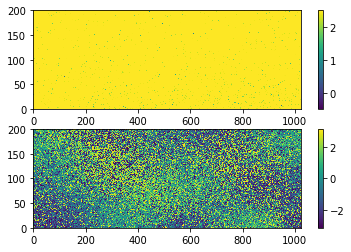

In [18]:

for i in faulty_predictions:
    print(i)
    plot_one_vis(dataset[i], 200)